In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import os
import time
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, optimizers, layers, metrics, models, regularizers

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle("Data/df_with_history.pkl")

In [3]:
X = df.loc[:, ["prev_date", "kg_ordered", "prod_group", "silo_nr", "kg_delivered",
                     "RU Geit", "RU Grond", "RU Kalv", "RU Melkv", "RU Vlvee", "Rundvee",
                     "t_5", "t_4", "t_3", "t_2", "t_1"]]

y = df["difference"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [6]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(np.asarray(y_train).reshape(-1,1))

X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(np.asarray(y_test).reshape(-1,1))

X_val = scaler.fit_transform(X_val)
y_val = scaler.fit_transform(np.asarray(y_val).reshape(-1,1))

In [7]:
model = Sequential()
model.add(layers.Dense(16, input_shape=(16,), activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

In [8]:
model.compile(optimizer="adagrad", loss="mean_squared_error", metrics=tf.keras.metrics.RootMeanSquaredError())
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), use_multiprocessing=True)

Epoch 1/15
5956/5956 [==============================] - 7s 1ms/step - loss: 3.6315 - root_mean_squared_error: 1.9048 - val_loss: 1.9459 - val_root_mean_squared_error: 1.3938
Epoch 2/15
5956/5956 [==============================] - 6s 1ms/step - loss: 3.0326 - root_mean_squared_error: 1.7405 - val_loss: 1.9225 - val_root_mean_squared_error: 1.3854
Epoch 3/15
5956/5956 [==============================] - 6s 1ms/step - loss: 2.8546 - root_mean_squared_error: 1.6886 - val_loss: 1.9183 - val_root_mean_squared_error: 1.3839
Epoch 4/15
5956/5956 [==============================] - 6s 993us/step - loss: 2.7391 - root_mean_squared_error: 1.6541 - val_loss: 1.9158 - val_root_mean_squared_error: 1.3830
Epoch 5/15
5956/5956 [==============================] - 7s 1ms/step - loss: 2.6713 - root_mean_squared_error: 1.6334 - val_loss: 1.9145 - val_root_mean_squared_error: 1.3825
Epoch 6/15
5956/5956 [==============================] - 6s 1ms/step - loss: 2.6117 - root_mean_squared_error: 1.6151 - val_loss:

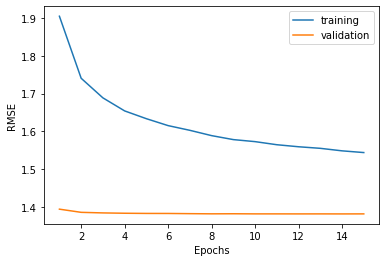

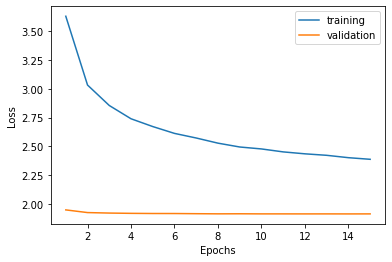

In [9]:
rmse_history = history.history["root_mean_squared_error"]
val_rmse_history = history.history["val_root_mean_squared_error"]

plt.plot(range(1, len(rmse_history) + 1), rmse_history)
plt.plot(range(1, len(val_rmse_history) + 1), val_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(["training", "validation"])
plt.show()

loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]

plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

In [10]:
val_pred = model.predict(X_val).ravel()
test_pred = model.predict(X_test).ravel()

In [12]:
inv_val_pred = scaler.inverse_transform(val_pred.reshape(-1, 1))
inv_y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

inv_test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))
inv_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_val = mean_squared_error(inv_y_val, inv_val_pred)
mse_test = mean_squared_error(inv_y_test, inv_test_pred)

print("RMSE on validation set:", np.sqrt(mse_val))
print("RMSE on test set:", np.sqrt(mse_test))

RMSE on validation set: 16.575832
RMSE on test set: 15.737692


In [13]:
percentages = []

for idx, val in enumerate(inv_test_pred):
    perc = np.abs(val-inv_y_test[idx])/inv_y_test[idx]
    percentages.append(perc[0])

In [14]:
print(f"Minimum percent error: {np.round(np.min(percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(percentages),2)}")

Minimum percent error: 0.0
Maximum percent error: 37.20000076293945
Mean percent error: 0.7799999713897705


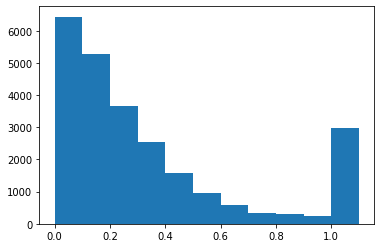

In [15]:
percentages = np.asarray(percentages)

plt.hist(percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [16]:
lower = []

for i in percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(percentages),2)}")

Number of orders with a percent error lower than 0.5: 19487
Percentage of orders with a percent error lower than 0.5: 0.78


In [17]:
differences = []

for idx, val in enumerate(inv_y_test):
    differences.append(np.abs(val[0]-inv_test_pred[idx][0]))

In [18]:
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in differences]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in differences]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in differences]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in differences]

In [19]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(differences),2)}")

Percentage of orders predicted correctly within 1 day: 0.25
Percentage of orders predicted correctly within 3 days: 0.51
Percentage of orders predicted correctly within 5 days: 0.67
Percentage of orders predicted correctly within 7 days: 0.78
